## Find a slid and check all alternative stable states

Packages

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import math

Define the network layer: calcuate the time derivatives. Optimiaztion wants to find points with zero derivatives, i.e., fixed points.

In [211]:
class SolveAltSS(nn.Module):
    def __init__(self,Ns_sub,Nr,Sstar,Rstar):
        super(SolveAltSS, self).__init__()
        self.Ns = Ns_sub
        self.Nr = Nr
        self.Star = nn.Parameter(torch.cat((Sstar,Rstar)))

    def forward(self, G, C, delta, gamma):
        dudt = torch.zeros_like(self.Star)
        dudt[:self.Ns] = self.Star[:self.Ns]*(self.Star[self.Ns:] @ G.transpose(0,1) - delta)
        dudt[self.Ns:] = gamma - self.Star[self.Ns:] * (self.Star[:self.Ns] @ C)

        return dudt, self.Star
    
def Lossfun(dudt, Star):
    loss = torch.norm(dudt) + 100*torch.sum(nn.functional.relu(-(Star - 1.0e-5)))
    return loss

Given $G$, $C$, $R^*$, and $S^*$.

In [212]:
Ns = 12
Nr = 12

rho = 0.5
# sampling 
sample = torch.rand(Ns,2,Nr)
L = torch.tensor([[1, 0],
                 [rho, math.sqrt(1-rho**2)]]) # Cholesky decomposition
sample = torch.matmul(L,sample)

G = sample[0:Ns,0]
C = sample[0:Ns,1] # C has not been pushed away

C = C @ torch.diag(0.01+ 0.99*torch.rand(Nr))

Sstar = 0.01 + 0.99*torch.rand(Ns)
Rstar = 0.01 + 0.99*torch.rand(Nr)

# can create gamma and delta
delta = Rstar @ G.transpose(0,1)
gamma = Rstar * (Sstar @ C)

Choose one subset of species

In [213]:
Ns_sub = 1 # run from 1 to 5 (int(12-1)/2?) (also get 11 to 7), 6 and 12 are run separately

sub_cmbins = torch.combinations(torch.tensor(range(Ns)), r=Ns_sub) # keep r lower than 5
num_cmbins = sub_cmbins.size(dim=0)

# for cmbins = range(num_cmbins)
cmbins = 0
self_spe_name = sub_cmbins[cmbins]
uniques, counts = torch.cat((self_spe_name, torch.tensor(range(Ns)))).unique(return_counts=True)
other_spe_name = uniques[counts == 1]
#spe_names = {self_spe_name, other_spe_name}

# for other in [0,1]: (we choose other = 1)
other = 1
if other == 1:
    spe_name = other_spe_name
    complement = self_spe_name
else:
    spe_name = self_spe_name
    complement = other_spe_name


Given the names of species, we can look at the submatrices.

In [214]:
G_sub = G[spe_name,:]
C_sub = C[spe_name,:]
S_sub = Sstar[spe_name]

delta_sub = delta[spe_name]

Fininally, we can do optimization

In [239]:
optisolver = SolveAltSS(len(spe_name),Nr,S_sub,Rstar)
optimizer = optim.Adam(optisolver.parameters())

lossv = 1
losses = []
epoch = 1
Star = torch.zeros(len(spe_name)+Nr)

while lossv > 0.005:

    optimizer.zero_grad()

    dudt, Star = optisolver(G_sub, C_sub, delta_sub, gamma)
    loss = Lossfun(dudt,Star)

    loss.backward()

    optimizer.step()

    lossv = loss.item()
    Star = Star.detach()
    losses.append(lossv)
    if epoch >= 100000:
        break

    epoch = epoch + 1

print('The last loss is %.4f' % lossv)

The last loss is 0.0050


Text(0, 0.5, 'Loss, norm of time derivatives')

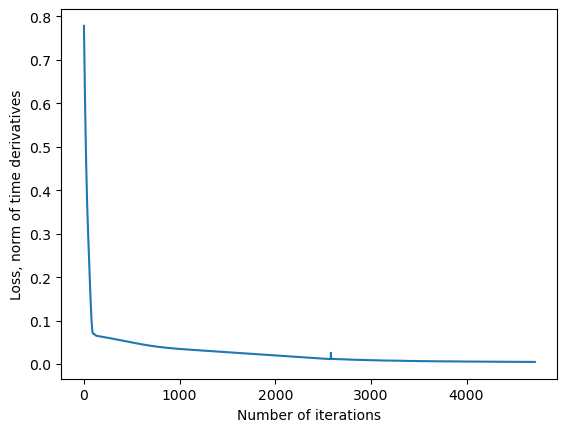

In [240]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(losses)
plt.xlabel('Number of iterations')
plt.ylabel('Loss, norm of time derivatives')

Calculate whether invadable

In [241]:
invade = (Star[len(spe_name):] @ G.transpose(0,1) - delta)[complement]
len(invade[invade>0]) > 0 # invadable

True

Test stability

In [242]:
Jstar = torch.zeros(len(spe_name)+Nr,len(spe_name)+Nr)
Jstar[:len(spe_name),len(spe_name):] = torch.diag(Star[:len(spe_name)]) @ G_sub
Jstar[len(spe_name):,:len(spe_name)] = - torch.diag(Star[len(spe_name):]) @ C_sub.transpose(0,1)
Jstar[len(spe_name):,len(spe_name):] = - torch.diag(C_sub.transpose(0,1) @ Star[:len(spe_name)])

Eig_J = torch.linalg.eigvals(Jstar).real
len(Eig_J[Eig_J >= 1.0e-3]) > 0 # unstable

True

Write a function that iterate all

In [243]:
from FindAltSSfuncs import FindAltSS

In [244]:
FindAltSS(1,G,C,Sstar,Rstar)

tensor([11., 11.])

# Let's sample $G$, $C$, $S^*$, and $R^*$ needed

In [245]:
from pathlib import Path

num_rho = 12
rho_span = torch.zeros(num_rho)
rho_span[:int(num_rho/2)] = torch.linspace(0, .85, steps=int(num_rho/2))
rho_span[int(num_rho/2):] = torch.linspace(.87, 1, steps=int(num_rho/2))

Csample = torch.zeros(num_rho,Ns,Nr)
Gsample = torch.zeros(num_rho,Ns,Nr)
Rsample = torch.zeros(num_rho,Nr)
Ssample = torch.zeros(num_rho,Ns)

for i in range(num_rho):
    rho = rho_span[i]
    sample = torch.rand(Ns,2,Nr)
    L = torch.tensor([[1, 0],
                    [rho, math.sqrt(1-rho**2)]]) # Cholesky decomposition

    sample = torch.matmul(L,sample)

    G = sample[0:Ns,0]
    Gsample[i] = G

    C = sample[0:Ns,1] # C has not been pushed away

    C = C @ torch.diag(0.01+ 0.99*torch.rand(Nr))
    Csample[i] = C

    Sstar = 0.01 + 0.99*torch.rand(Ns)
    Rstar = 0.01 + 0.99*torch.rand(Nr)
    Ssample[i] = Sstar
    Rsample[i] = Rstar

datapath = Path('./data/').expanduser()
tensorfile = {'C_span': Csample, 'G_span': Gsample, 'R_span': Rsample, 'S_span': Ssample}
torch.save(tensorfile, datapath/'AltSSsamples.pt')

In [249]:
loaded = torch.load(datapath/'AltSSsamples.pt')
C_span = loaded['C_span']
C_span[0] - Csample[0]

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [258]:
task_id = 0
AltSSdiv = torch.zeros(2)
filename = 'AltSSdiv'+str(task_id)+'.pt'
torch.save({'AltSSdiv': AltSSdiv}, datapath/filename)
torch.load(datapath/filename)['AltSSdiv']

tensor([0., 0.])